### References:
- [Mandel 2009](https://arxiv.org/pdf/0912.5531.pdf)
- [Hogg et al. 2010](https://iopscience.iop.org/article/10.1088/0004-637X/725/2/2166/pdf)

### Examples:
- [Antoniadis et al. 2016](http://arxiv.org/abs/1605.01665)
- [Mandel et al. 2018](https://arxiv.org/pdf/1807.09772.pdf)

In [1]:
import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
%matplotlib inline

# Package versions:
print('Running on:')
print('\tNumpy\t\t{}'.format(np.__version__))
print('\tPyMC3\t\t{}\n'.format(pm.__version__))

rand_seed = np.random.randint(0, 2**32 - 1)
print('Random seed:',rand_seed)

Running on:
	Numpy		1.16.2
	PyMC3		3.5

Random seed: 3890211655


The distribution models I want to test are gaussian and bimodal, so I define functions to estimate probability density of a given $x$ in these distributions. Note that these are probability densities ($\int f(x)~dx = 1$).

$$ \text{Bimodal}(x | \mu_1, \sigma_1, w_1, \mu_2, \sigma_2) = w_1~\text{Normal}(x|\mu_1,\sigma_1) + (1-w_1)~\text{Normal}(x|\mu_2,\sigma_2) $$

Note that the definitions below are written in a way so that they can handle `theano` variables.

In [2]:
def gaussian(x, mu, sd):
    return 1./(np.sqrt(2.*np.pi)*sd)*np.exp(-np.power((x - mu)/sd, 2.)/2)

def bimodal(x, mu1, sd1, w1, mu2, sd2):
    return (gaussian(x, mu1, sd1) * w1 + gaussian(x, mu2, sd2) * (1-w1))

def trunacated_bimodal(x, mu1, sd1, w1, mu2, sd2):
    """
    Similar to the bimodal function above, but it returns 0 for x < 0.
    This is because negative values are meaningless in this case (prior information).
    To implement this in a theano-consistent way, I use the switch function in PyMC.
    This then requires x to be a theano variable. 
    
    THIS FUNCTION IS NOT NORMALIZED.
    
    """
    return pm.math.switch(x >= 0, gaussian(x, mu1, sd1) * w1 + gaussian(x, mu2, sd2) * (1-w1), 0)

Data consists of posterior PDFs for 16 black hole systems (events) from independent simulations. So I create a data matrix $K$, where $K_{ij}$ is $j$-th realization from the posterior PDF for event $i$. I take 10000 realizations for each event, thus $i=16$ and $j=10000$.

In [3]:
data_dir = '../../../home/arash/Dropbox/Natal_kicks_data/Re_fit/'
data_01 = np.loadtxt(data_dir+"Cyg X-1_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_02 = np.loadtxt(data_dir+"GX339-4_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_03 = np.loadtxt(data_dir+"GS1354-64_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_04 = np.loadtxt(data_dir+"1A 0620-00_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_05 = np.loadtxt(data_dir+"GR01655-40_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_06 = np.loadtxt(data_dir+"GS1124-684_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_07 = np.loadtxt(data_dir+"SwiftJ1753_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_08 = np.loadtxt(data_dir+"GRS1915+105_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_09 = np.loadtxt(data_dir+"XTEJ1118+480_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_10 = np.loadtxt(data_dir+"MAXIJ1836-194_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_11 = np.loadtxt(data_dir+"GRS1716-249_natalkicks_dist_-10.txt", comments="#", delimiter=" ", unpack=False)
data_12 = np.loadtxt(data_dir+"4U1543-475_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_13 = np.loadtxt(data_dir+"SAXJ1819-2525_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_14 = np.loadtxt(data_dir+"MAXIJ1820+070_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_15 = np.loadtxt(data_dir+"V404Cyg_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)
data_16 = np.loadtxt(data_dir+"VLAJ2130_natalkicks_dist.txt", comments="#", delimiter=" ", unpack=False)

dist_01 = data_01[:10000]
dist_02 = data_02[:10000]
dist_03 = data_03[:10000]
dist_04 = data_04[:10000]
dist_05 = data_05[:10000]
dist_06 = data_06[:10000]
dist_07 = data_07[:10000]
dist_08 = data_08[:10000]
dist_09 = data_09[:10000]
dist_10 = data_10[:10000]
dist_11 = data_11[:10000]
dist_12 = data_12[:10000]
dist_13 = data_13[:10000]
dist_14 = data_14[:10000]
dist_15 = data_15[:10000]
dist_16 = data_16[:10000]

K = np.array([dist_01,dist_02,dist_03,dist_04,
              dist_05,dist_06,dist_07,dist_08,
              dist_09,dist_10,dist_11,dist_12,
              dist_13,dist_14,dist_15,dist_16])

print(np.shape(K))

(16, 10000)


I use the hierarchical method outlined by [Mandel 2009](https://arxiv.org/pdf/0912.5531.pdf) and [Hogg et al. 2010](https://iopscience.iop.org/article/10.1088/0004-637X/725/2/2166/pdf):

$$ p(f(\lambda)|p_1(\lambda),\cdots p_k(\lambda)) \propto \pi(f(\lambda)) \prod_{i=1}^{k} \left[ \frac{1}{N_i} \sum_{j=1}^{N_i} f(\lambda_i^{(j)}) \right]$$

Our model here is a bimodal distribution, all priors are flat, but with boundaries based on expectations based data and degenaracies. So:

$f(\lambda_i^{(j)}) = \text{Bimodal}(\lambda_i^{(j)}, \mu_1, \sigma_1, w_1, \mu_2, \sigma_2) =$  `bimodal(K,mu1,sd1,w1,mu2,sd2)`

Given all our event PDFs have the same number of realizations ($N_i$), thus $\prod \frac{1}{N_i} = 10^{-20}$.

Also, from the physics of the problem, we know $\lambda >= 0$, thus we use the `trunacated_bimodal` function defined above, which simply returns $f(\lambda) = 0$ if $\lambda < 0$.

Note that this is just a quick example, thus chains and sample sizes are chosen to be rather small.

In [4]:
with pm.Model() as model:
    mu1 = pm.Uniform('mu1',5,80)
    sd1 = pm.Uniform('sd1',5,40)
    w1 = pm.Uniform('w1',0.0,1.0)
    mu2 = pm.Uniform('mu2',100,200)
    sd2 = pm.Uniform('sd2',10,100)
    
    likelihood = pm.Potential('log-likelihood',np.log(trunacated_bimodal(K,mu1,sd1,w1,mu2,sd2).sum(axis=1).prod()/1e20))
    
    # to read previous run:
    #trace = pm.backends.text.load('hogg_trace_db')[1000:]
    
    # to run:
    step_method = pm.NUTS()
    trace = pm.sample(1000, chains=12, cores=12, tune=500, random_seed=rand_seed, step_methode=step_method)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sd2, mu2, w1, sd1, mu1]
Sampling 12 chains: 100%|██████████| 18000/18000 [06:54<00:00, 43.38draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu1,45.748107,14.128576,0.188428,25.645902,79.952592,5310.984860,1.000512
sd1,19.965417,9.945068,0.129021,5.003321,37.400213,4762.807648,1.000255
w1,0.338589,0.158084,0.001863,0.015161,0.622065,5815.198767,1.000844
mu2,136.221555,16.917608,0.209593,100.006002,164.927554,6155.888835,1.000419
sd2,35.595967,18.341550,0.247386,10.001120,69.671968,5379.610574,0.999833


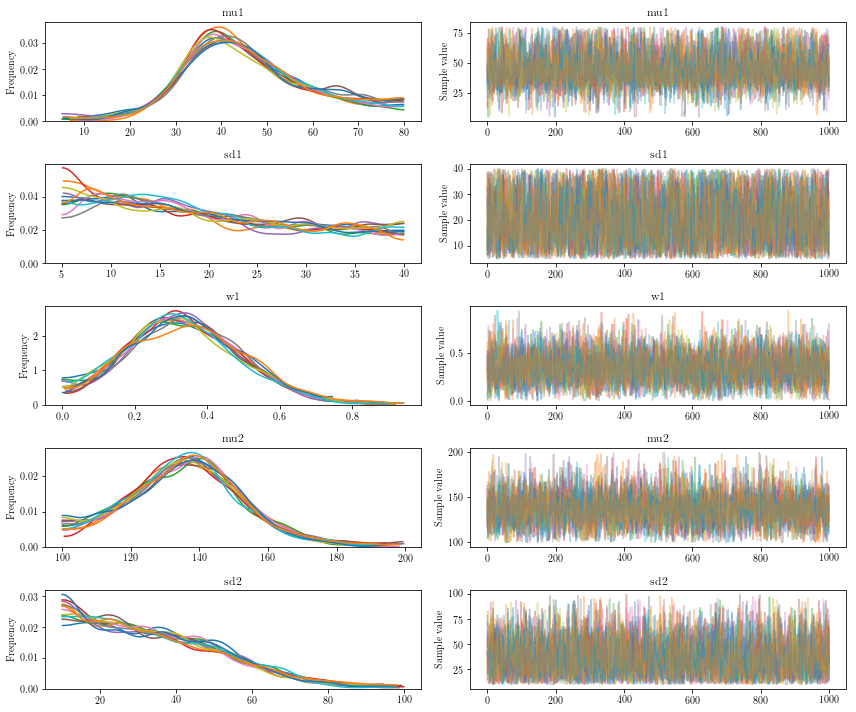

In [5]:
pm.traceplot(trace)
pm.summary(trace).round(20)

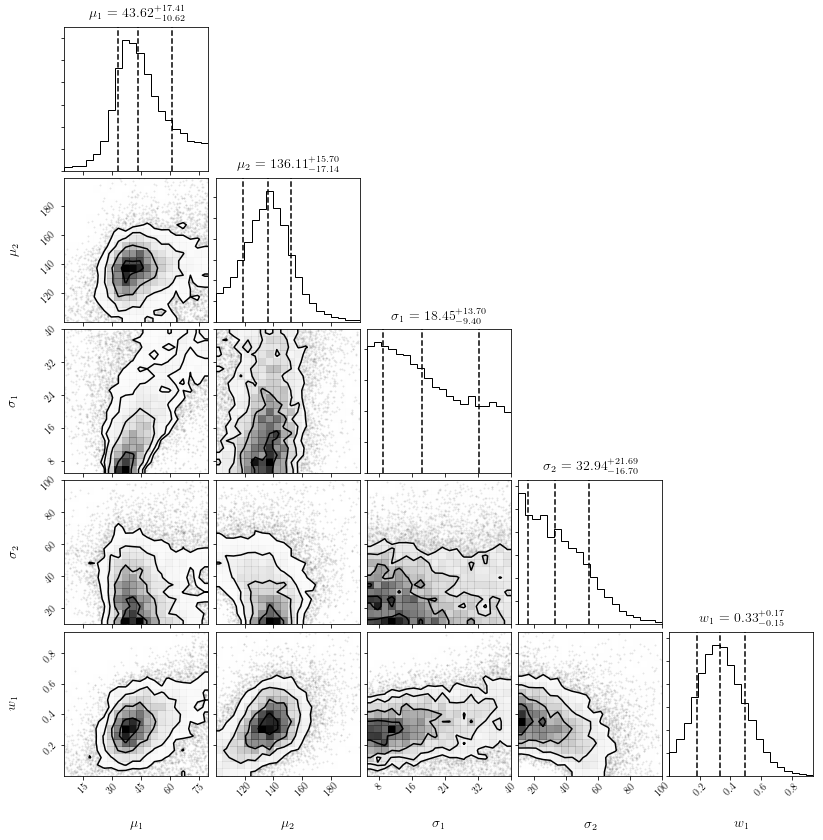

In [6]:
import corner

corner_data = list(zip(*np.array([trace.get_values('mu1').transpose(),
                                  trace.get_values('mu2').transpose(),
                                  trace.get_values('sd1').transpose(),
                                  trace.get_values('sd2').transpose(),
                                  trace.get_values('w1').transpose()])))

cornplot = corner.corner(corner_data,quantiles=[0.16,0.5,0.84],show_titles=True,use_math_text=False,
                         labels = [r'$\mu_1$',r'$\mu_2$',r'$\sigma_1$',r'$\sigma_2$','$w_1$'],
                         title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 14})

#cornplot.set_figheight(9)
#cornplot.set_figwidth(9)
#cornplot.savefig('hogg_corner.pdf',bbox_inches='tight')

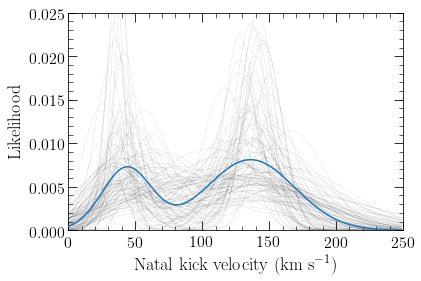

In [7]:
plt_x = np.arange(0,250,1.0)
plt.plot(plt_x, bimodal(plt_x, 
                        np.median(trace.get_values('mu1')), np.median(trace.get_values('sd1')),  
                        np.median(trace.get_values('w1')),
                        np.median(trace.get_values('mu2')), np.median(trace.get_values('sd2'))),zorder=10)

for i in np.random.randint(0,5000,size=100):
    plt.plot(plt_x, bimodal(plt_x, 
                            trace.get_values('mu1')[i], trace.get_values('sd1')[i],
                            trace.get_values('w1')[i],
                            trace.get_values('mu2')[i], trace.get_values('sd2')[i]),'k', lw=0.1, alpha=0.5)


plt.xlim(0,250)
plt.ylim(0,0.025)
#plt.legend(loc=1, fontsize=24);
plt.xlabel('Natal kick velocity (km s$^{-1}$)', fontsize=18)
plt.ylabel('Likelihood', fontsize=18)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig('/home/arash/Dropbox/Natal_kicks_data/hogg_results_2g.pdf',bbox_inches='tight')